### **Mustererkennung in Audiodaten**: Emotionserkennung aus gesprochener Sprache mittels auditiver Datenanalyse, Machine Learning und Neuronalen Netzen, umgesetzt in einer interaktiven Streamlit-Anwendung

#🎤 **Spracherkennung von Emotionen mit Deep Learning**

In diesem Notebook wird mit Audiodaten aus der **RAVDESS-Datenbank** und einer Kombination von DL-Algorithmen (**CNN** und **RNN**) ein neuronales Netz zur **Emotionserkennung in Sprache** trainiert.  

Ziel des Projekts:  
+ Entwicklung eines Deep-Learning-Modells, das Emotionen in Sprache erkennt
+ Eingabe: Audiodateien (z. B. „.wav“)
+ Ausgabe: Wahrscheinlichkeiten von 8 Emotionen (z. B. happy, sad, angry …).



+ **CNN** = Ein Convolutional Neural Network (faltendes NN) ist eine Deep Learning-Struktur, die am häufigsten zur Analyse und zum Lernen **visueller** Merkmale aus großen Datenmengen eingesetzt wird.

+ **RNN** = Ein Recurrent Neural Network (rückgekoppeltes NN) ist eine Netzwerkarchitektur für Deep Learning, die Vorhersagen auf der Grundlage von Zeitreihen oder **sequenziellen** Daten trifft.

   + **LSTM** (Long Short-Term Memory) ist Typ eines RNN, das darauf spezialisiert ist, langfristige Abhängigkeiten in sequenziellen Daten zu lernen.







####

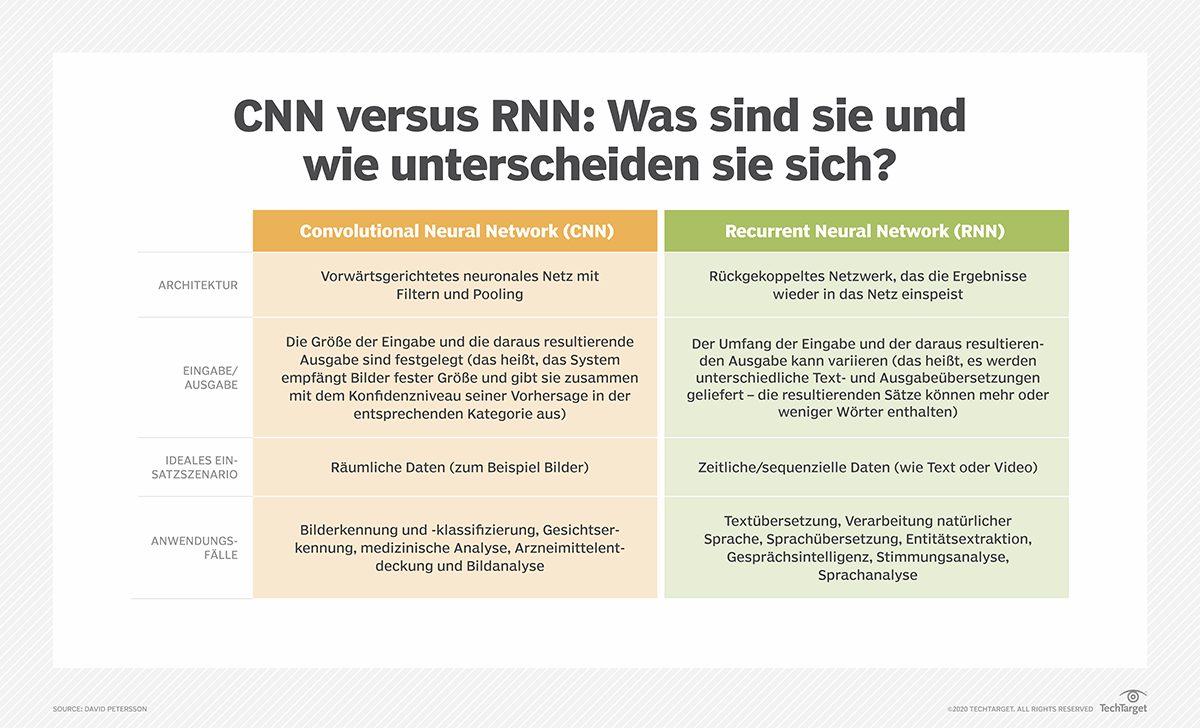

---

## 0. Setup & Imports  



+ Bibliotheken für:
   + **Audioverarbeitung**: `librosa`
   + **Datenanalyse & Visualisierung**: `numpy`, `pandas`, `matplotlib`, `seaborn`
   + **ML / DL**: `scikit-learn`, `tensorflow.keras`
+ Google Drive wird eingebunden, um Daten und Modelle zu speichern.
   + Nutzung von Google Colab → ermöglicht Training in der Cloud mit GPU

##

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LSTM,TimeDistributed, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##

###**Librosa**
+ Musik- und Audioanalyse
+ Damit können Systeme zum Abrufen von Musikinformationen erstellen werden
+ Feature Extraktion

###**TensorFlow**

+ Open-Source-Framework für ML und DL, entwickelt von Google
+ es können neuronale Netze definiert, trainiert und eingesetzt werden
+ 3 versch. Modellarchitekturen:
  + Sequential
  + Functional
  + Subclassing
+ Anwendungsfälle  
   + Bildverarbeitung (CNNs: Gesichtserkennung, Objekterkennung)
   + Sprachverarbeitung (RNNs/LSTMs: Emotionserkennung, Übersetzung, Sprachassistenten)
   + Zeitreihenanalyse (Vorhersagen, Anomalieerkennung)
   + Recommendation Systems (Netflix, YouTube)
   + Forschung & Produktion → Modelle können leicht auf Servern, Smartphones etc. laufen

#### Aufbau & Funktionsweise
+ Tensoren  
  + „Tensor“ = Datenstruktur   
  (z. B. Skalar, Vektor, Matrix, n-dimensionale Arrays).  
  Beispiel:  
    + Skalar: 5  
    + Vektor: [1, 2, 3]  
    + Matrix: [[1, 2], [3, 4]]  
    + Tensor 3D: „Stapel“ von Matrizen  
   + TensorFlow berechnet Operationen von diesen Tensoren (oft mit GPU-Beschleunigung).  

+ Computational Graph  
Modelle werden als Graphen von Operationen dargestellt:  
   + Knoten = Operation (z. B. Matrixmultiplikation, Aktivierungsfunktion)  
   + Kanten = Tensoren (Daten, die fließen)  

+ Backpropagation  
   + geht rückwärts durch die Schicht um Fehler zu verringern

   TensorFlow kümmert sich automatisch um Ableitungen und Gradientenberechnung → nötig für das Training von Netzen

#### Vorteile
+ GPU/TPU-Unterstützung → extrem schnell  
+ Automatische Gradientenberechnung  
+ Große Community, viele vortrainierte Modelle  
+ Läuft in Python, aber auch in C++, JavaScript (tf.js), Swift  
+ Deployment auf Mobilgeräten mit TensorFlow Lite  

#### **großer** Nachteil
+ Kompatibilitätsprobleme mit anderen Bibliotheken

#### TensorFlow hier  
+ Definition des Modells: CNN + LSTM + Dense Layers
+ Training: Optimierer (Adam) passt Gewichte an → Minimierung des Loss
+ Evaluation: Genauigkeit & Fehleranalyse
+ Speicherung: Modell wird als .keras Datei exportiert
+ Vorhersage: Neue Audiodateien können klassifiziert werden


---

## 1. Pfade

+ **Dataset-Pfad**: Ordner mit WAV-Dateien
+ **Speicherpfade**: für das trainierte Modell (`.keras`) und den LabelEncoder (`.pkl`)

In [ ]:
dataset_path = "/content/drive/MyDrive/DSI_Abschlussprojekt/Audio_Speech_Actors_01-24"
save_model_path = "/content/drive/MyDrive/DSI_Abschlussprojekt/trained_models/cnn_lstm_emotion_model_5dim.keras"
save_encoder_path = "/content/drive/MyDrive/DSI_Abschlussprojekt/trained_models/label_encoder.pkl"

---

## 2. Feature Extraktion

+ Rohes Audiosignal wird in **aussagekräftige Merkmale** umgewandelt:
   + **MFCCs** (Mel-Frequency Cepstral Coefficients) → timbre/Sprachcharakteristik
   + **Delta & Delta²** → Veränderungen im Zeitverlauf
   + **Mel-Spektrogramm** → Energieverteilung
   + **Chroma** → Tonhöheninformationen
+ Alle Features werden auf gleiche Länge gebracht (Padding) → gleichgroße Tensoren
+ Am Ende: **5-dimensionaler Feature-Tensor** pro Audiodatei

In [ ]:
def extract_features_from_signal(signal, sr, max_len=216):
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr, n_chroma=40)

    def pad(x, max_len=max_len):
        if x.shape[1] < max_len:
            return np.pad(x, ((0,0),(0,max_len-x.shape[1])), mode="constant")
        else:
            return x[:, :max_len]

    mfcc = pad(mfcc)
    delta = pad(delta)
    delta2 = pad(delta2)
    mel = pad(mel)
    chroma = pad(chroma)

    return np.stack([mfcc, delta, delta2, mel[:40], chroma[:40]], axis=-1)

def extract_features(file_path, max_len=216, sr=22050):
    signal, sr = librosa.load(file_path, sr=sr)
    return extract_features_from_signal(signal, sr, max_len=max_len)


---

## 3. Daten laden

+ WAV-Dateien werden eingelesen
+ **Labels** werden aus Dateinamen extrahiert (z. B. 03-01-***05***-02-...-03.wav → „angry“)
+ **Datenaugmentation**: künstliche Variationen für robusteres Training
   + Hinzufügen von Rauschen
   + Pitch-Shift (Tonhöhe verändern)
   + Time-Stretch (langsamer / schneller)
+ Ergebnis: ca. 2,5mal mehr Trainingsdaten

In [ ]:
X, y = [], []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_id = int(file.split("-")[2])
            label = {
                1:"neutral", 2:"calm", 3:"happy", 4:"sad",
                5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"
            }[emotion_id]

            try:
                # Original
                features = extract_features(file_path)
                X.append(features)
                y.append(label)

                # Augmentations
                signal, sr = librosa.load(file_path, sr=22050)

                if random.random() < 0.5:
                    aug = signal + 0.005 * np.random.randn(len(signal))
                    X.append(extract_features_from_signal(aug, sr))
                    y.append(label)

                if random.random() < 0.5:
                    aug = librosa.effects.pitch_shift(signal, sr=sr, n_steps=random.uniform(-2,2))
                    X.append(extract_features_from_signal(aug, sr))
                    y.append(label)

                if random.random() < 0.5:
                    rate = random.uniform(0.8, 1.2)
                    aug = librosa.effects.time_stretch(signal, rate=rate)
                    X.append(extract_features_from_signal(aug, sr))
                    y.append(label)

            except Exception as e:
                print("Fehler bei:", file_path, e)

X = np.array(X)
y = np.array(y)

print("Feature-Array:", X.shape)
print("Labels:", y.shape)


Feature-Array: (3573, 40, 216, 5)
Labels: (3573,)


---

## 4. Daten vorbereiten

+ Labels werden numerisch codiert (LabelEncoder) → anschließend One-Hot-Encoding.
+ Train-Test-Split: 80 % Training, 20 % Test, stratifiziert nach Emotionen.

In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc, num_classes=len(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2858, 40, 216, 5) Test: (715, 40, 216, 5)


---

## 5. Modell

+ **Modellaufbau** in TensorFlow/Keras:  

  +  **CNN-Block**: extrahiert lokale Muster in Zeit-Frequenz-Daten (Spektrogrammen) mit Conv2D + BatchNorm + MaxPooling + Dropout
  + **Reshape**: Form wird in Sequenzen überführt
    + Dimensionen werden verringert → 2D
    + Anzahl der Werte bleibt gleich
  + **LSTM-Schicht**: lernt zeitliche Abfolgen (wie Emotionen sich im Verlauf der Sprache entwickeln)
  + **Dense-Layer**: kombiniert die gelernten Merkmale und liefert die Klassifikation in 8 Emotionen mit Softmax
    + vollständig verbundene Schicht
    + Jedes Neuron ist mit allen Neuronen der vorherigen Schicht verbunden.
+ **Aktivierungsfunktionen**:
  + **ReLU** (Rectified Linear Unit) in versteckten Schichten → schnelle, effiziente Berechnung
    + Nichtlinearität → Netz kann komplexe Muster lernen
    + Negative Werte → 0
    + Positive Werte → unverändert
    + Ergebnis: nur manche Neuronen „feuern“ → sparsames Lernen
  + **Softmax** in der letzten Schicht → gibt Wahrscheinlichkeiten für jede Emotion zurück
+ **Training** mit:
  + Optimierungsalgorithmus *Adam* (Adaptive Moment Estimation)
    + steuert die adaptive Lernrate im Modell
  + Regularisierung (*Dropout*, *EarlyStopping*)
  + *Loss* = `categorical_crossentropy`
    + quantifiziert den Unterschied zwischen Test und Trainingsdaten

In [ ]:
input_shape = X_train.shape[1:]

model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Reshape((X_train.shape[1], -1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(len(le.classes_), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 216, 32)    │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 216, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 864)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       237,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,528 (1.02 MB)

 Trainable params: 267,336 (1.02 MB)

 Non-trainable params: 192 (768.00 B)

###

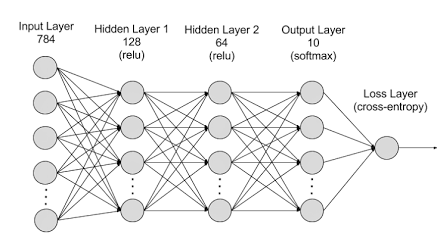

---

## 6. Training

+ Bis zu 50 Epochen, Batchsize 32
   + **Epoche**: kompletter Durchlauf durch den gesamten Trainingsdatensatz  
   + **Batchsize**: Anzahl der Trainingsbeispiele, die in einer Epoche vorwärts und rückwärts durch ein neuronales Netzwerk laufen
+ Callbacks:
   + **EarlyStopping**: bricht ab, wenn sich Val-Loss nicht mehr verbessert
   + **ReduceLROnPlateau**: Lernrate wird automatisch verkleinert, wenn Training stockt
   + **ModelCheckpoint**: bestes Modell wird gespeichert






In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5),
    ModelCheckpoint(save_model_path, save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.1700 - loss: 2.0517 - val_accuracy: 0.2671 - val_loss: 1.8604 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2665 - loss: 1.8751 - val_accuracy: 0.2811 - val_loss: 1.8274 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3549 - loss: 1.7099 - val_accuracy: 0.3455 - val_loss: 1.7114 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3728 - loss: 1.6357 - val_accuracy: 0.3972 - val_loss: 1.5502 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4234 - loss: 1.5208 - val_accuracy: 0.3986 - val_loss: 1.5593 - learning_rate: 0.0010
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4677 - loss: 1.4198 - val_accuracy: 0.3986 - val_loss: 1.5598 - learning_rate: 0.0010
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5097 - loss: 1.3392 - val_ac

---

## 7. Evaluation

In [ ]:
emotion_dict = {i: label for i, label in enumerate(le.classes_)}

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### Klassifizierungsbericht

**precision**: Wie viele der als Klasse X vorhergesagten Beispiele wirklich X waren. (Qualität der Vorhersagen)  
**recall**: Wie viele der echten X-Beispiele auch als X erkannt wurden. (Abdeckung)  
**f1-score**: Harmonisches Mittel aus precision & recall → wichtig bei unausgeglichenen Daten.  
**support**: Anzahl der Beispiele je Klasse.

👉 Beispiel:
Wenn "calm" eine precision von 0.57 hat, heißt das: Nur 57 % der Vorhersagen „calm“ waren wirklich korrekt.
Aber wenn der recall 0.82 ist, dann hat das Modell immerhin 82 % aller "calm"-Beispiele erkannt, auch wenn es dabei viele Verwechslungen gemacht hat.  

**Accuracy**: Wie viele Testdaten werden richtig klassifiziert.  

**Macro Average**: Der ungewichtete Durchschnitt über alle Klassen.  

**Weighted Average**: Die Werte nach der Häufigkeit der Klassen gewichtet.


              precision    recall  f1-score   support

       angry       0.73      0.78      0.75        95
        calm       0.57      0.82      0.67        93
     disgust       0.64      0.59      0.61        98
     fearful       0.75      0.50      0.60        96
       happy       0.73      0.54      0.62        98
     neutral       0.60      0.52      0.56        48
         sad       0.45      0.56      0.50        91
   surprised       0.78      0.77      0.77        96

    accuracy                           0.64       715
   macro avg       0.65      0.64      0.64       715
weighted avg       0.66      0.64      0.64       715



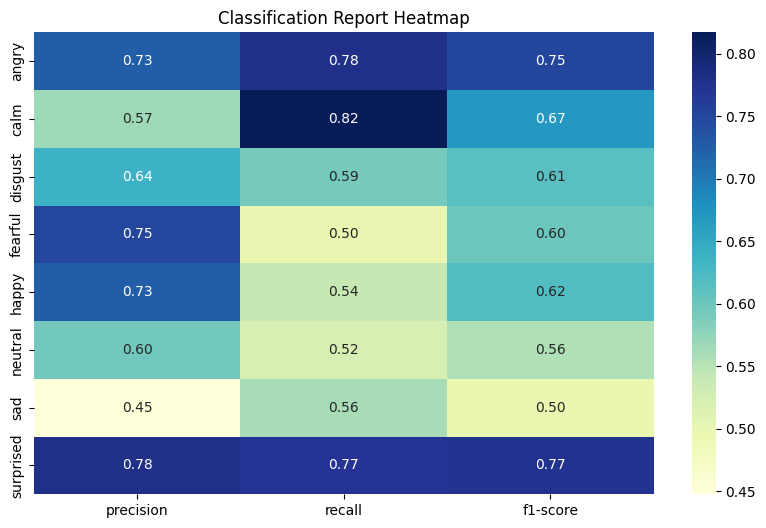

In [ ]:
# Classification Report
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=le.classes_, zero_division=0))

# Classification Report Heatmap
report_dict = classification_report(y_true_classes, y_pred_classes,
                                   target_names=le.classes_,
                                   output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()
plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-3,:3], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()

### Konfusionsmatrix  
Bewertung der Leistung von Klassifizierungsalgorithmen im Machine Learning. Verglichen werden die tatsächlichen und vorhergesagten Klassenzugehörigkeiten.

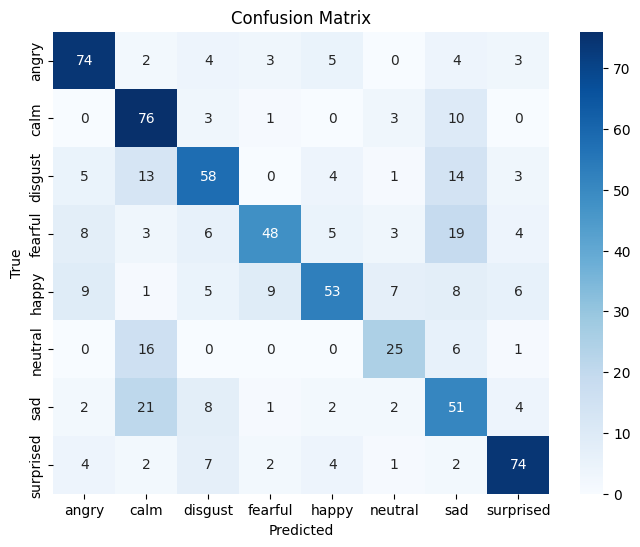

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Trainingskurven
Visualisierung der Accuracy und des Loss-Verlaufs während des Trainings.  

**Accuracy**: zeigt, wie gut das Modell im Training und auf den Validierungsdaten abschneidet.  
Wenn die Training-Accuracy steigt, die Validierungs-Accuracy aber stagniert → Überanpassung (Overfitting).  
**Loss**: misst, wie „falsch“ die Vorhersagen sind.
Loss sollte mit den Epochen sinken.  
Wenn Trainings-Loss sinkt, aber Val-Loss steigt → ebenfalls Overfitting.  

👉 Wichtig: gesucht werden möglist parallele Kurven, bei denen sowohl   Training als auch Validation stabil besser werden.


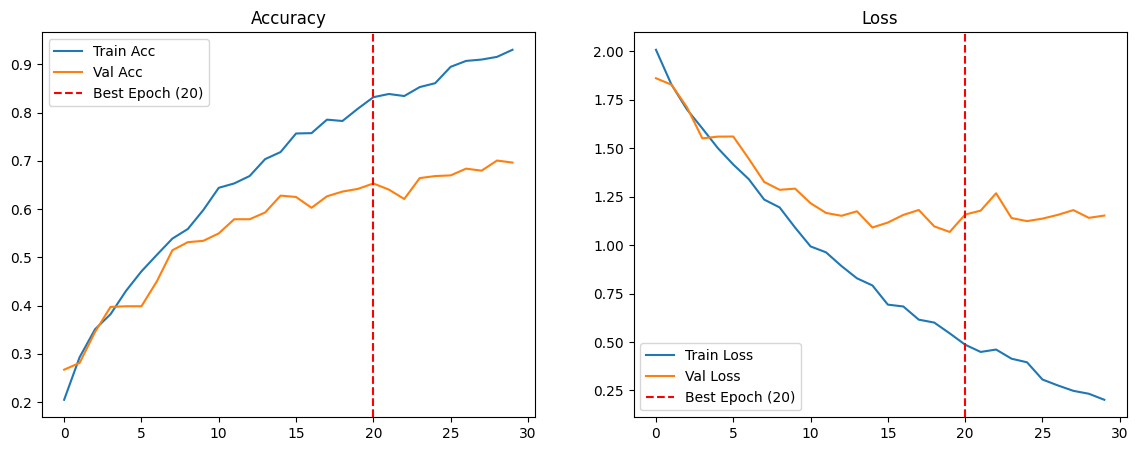

In [ ]:
# Beste Epoche anhand val_loss bestimmen
best_epoch = np.argmin(history.history['val_loss'])  # Index der besten Epoche (0-basiert)
best_epoch_display = best_epoch + 1  # für Anzeige (1-basiert)

# Accuracy / Loss Verlauf
plt.figure(figsize=(14,5))

# --- Accuracy ---
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.axvline(best_epoch_display, color='r', linestyle='--', label=f"Best Epoch ({best_epoch_display})")
plt.legend(); plt.title("Accuracy")

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.axvline(best_epoch_display, color='r', linestyle='--', label=f"Best Epoch ({best_epoch_display})")
plt.legend(); plt.title("Loss")

plt.show()


### Korrelationsmatrix

+ hilft, Verwechslungen zwischen Emotionen zu verstehen:
  + Positive Korrelation = Modell sieht Ähnlichkeiten → potenzielle „Konfusionsgefahr“
  + Negative Korrelation = Modell unterscheidet Emotionen klar
  + Beispiel:
    + Calm vs. Neutral → manchmal schwer zu trennen (leichte positive Korrelation)
    + Angry vs. Calm → klar gegensätzlich (starke negative Korrelation)

+ **Negative Werte** dominieren → das Modell unterscheidet Emotionen gut
+ einige **positive Korrelationen** (z. B. calm–neutral) zeigt, wo Emotionen vom Modell eher verwechselt werden

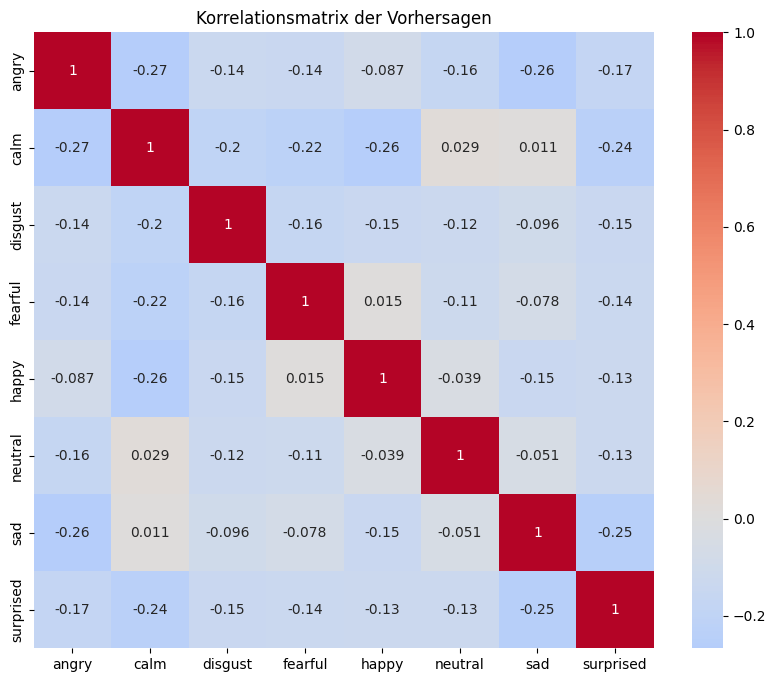

In [ ]:
# Korrelationsmatrix Vorhersagen
df_preds = pd.DataFrame(y_pred, columns=le.classes_)
plt.figure(figsize=(10,8))
sns.heatmap(df_preds.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix der Vorhersagen")
plt.show()

---

## 8. Speichern

Modell wird als ``.keras`` Datei gesichert.  
LabelEncoder als ``.pkl`` Datei – wichtig für spätere Vorhersagen.  
Das Modell kann direkt in einer Streamlit-App oder API genutzt werden.

In [ ]:
model.save(save_model_path)
joblib.dump(le, save_encoder_path)
print("✅ Model und LabelEncoder gespeichert.")

---

##Fazit & Ausblick

+ vollständige Pipeline zur Mustererkennung in Audiodaten:  
Audiodatei → Feature-Extraktion → Datenaugmentation → CNN-LSTM Modell → Evaluation → Speicherung  

+ mögliche Verbesserungen:
  + **deutlich** mehr Daten
  + Dropout, Länge verändern
  + weitere Features hinzufügen, z.B. Spectral Contrast

+ Anwendungsfälle:
   + Emotionserkennung in Callcentern
   + Therapeutische Assistenzsysteme
   + Mensch-Computer-Interaktion (z. B. Sprachassistenten)

+ Nächste Schritte:
   + Echtzeit-Erkennung
   + Feinere Emotionen (z. B. Ironie, Frustration)
   + Transfer Learning mit größeren oder vortrainierten Sprachmodellen